In [153]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.metrics import mean_squared_error


1: Read Data

In [154]:
MOVIE_DATA_PATH = "../data/external/movie/"

In [155]:
MOVIES = MOVIE_DATA_PATH + "movies.csv"
RATINGS = MOVIE_DATA_PATH + "ratings.csv"
TAGS =  MOVIE_DATA_PATH + "tags.csv"
LINKS = MOVIE_DATA_PATH + "links.csv"

In [156]:
movies_df = pd.read_csv(MOVIES, header=0)
ratings_df = pd.read_csv(RATINGS, header=0)
tags_df = pd.read_csv(TAGS, header=0)
links_df = pd.read_csv(LINKS, header=0)

In [157]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [158]:
movies_df.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [159]:
movies_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [160]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [161]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [162]:
ratings_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [163]:
# 9724 unique movies get rating
len(ratings_df.movieId.unique())

9724

In [164]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [165]:
tags_df.describe()

,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09


In [166]:
tags_df.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [167]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [168]:
links_df.isnull().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

2, Exploratory Data Analysis (EDA)

2.1 user rating analsis

In [169]:
# Aggregate by movie
users_ratings = ratings_df.groupby('userId').agg(number_user_ratings = ('rating', 'count')).reset_index()

In [170]:
# For each user, minimal number of ratings is 20
users_ratings.describe()

,userId,number_user_ratings
count,610.000000,610.000000
mean,305.500000,165.304918
std,176.236111,269.480584
min,1.000000,20.000000
25%,153.250000,35.000000
50%,305.500000,70.500000
75%,457.750000,168.000000
max,610.000000,2698.000000


<Axes: >

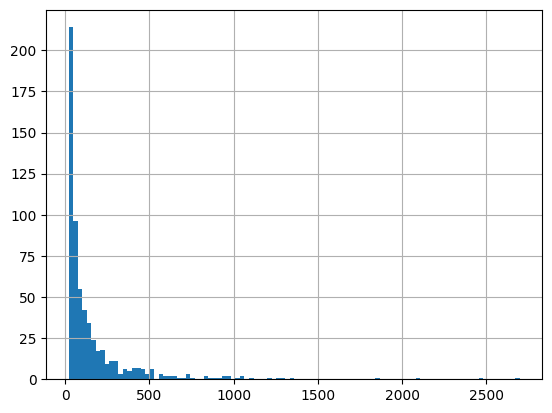

In [171]:
users_ratings["number_user_ratings"].hist(bins=100)

<Axes: >

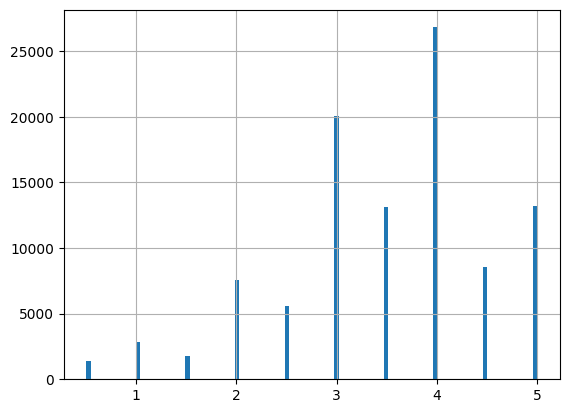

In [172]:
ratings_df['rating'].hist(bins=100)

2.2 The average ratings for the movies

In [173]:
# Aggregate by movie
agg_ratings = ratings_df.groupby('movieId').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

In [174]:
agg_ratings['number_of_ratings'].describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: number_of_ratings, dtype: float64

<Axes: >

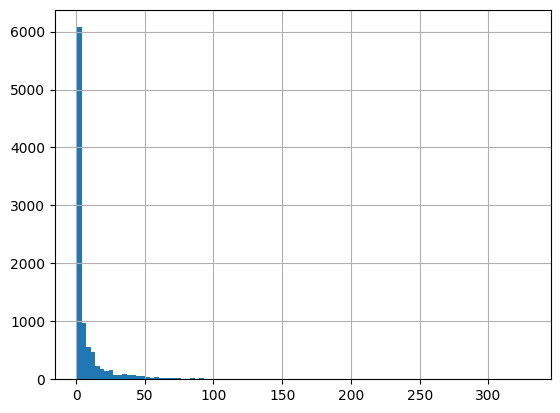

In [175]:
agg_ratings['number_of_ratings'].hist(bins=100)

2.3 top 50 movies for cold start

In [176]:
agg_ratings_gt200 = agg_ratings[agg_ratings['number_of_ratings']>200]

In [177]:
agg_ratings_gt200.sort_values(by="mean_rating", ascending=False)

,movieId,mean_rating,number_of_ratings
277,318,4.429022,317
2224,2959,4.272936,218
46,50,4.237745,204
224,260,4.231076,251
461,527,4.225000,220
897,1196,4.215640,211
257,296,4.197068,307
1938,2571,4.192446,278
314,356,4.164134,329
510,593,4.161290,279


In [178]:
top50_movies_id = agg_ratings_gt200.sort_values(by="mean_rating", ascending=False)['movieId']

In [179]:
top50_movies_id

277      318
2224    2959
46        50
224      260
461      527
897     1196
257      296
1938    2571
314      356
510      593
2144    2858
97       110
43        47
507      589
0          1
123      150
418      480
615      780
Name: movieId, dtype: int64

In [180]:
filtered_movies_df = movies_df[movies_df['movieId'].isin(top50_movies_id)]

In [181]:
top_50_movies = filtered_movies_df.set_index('movieId').loc[top50_movies_id]
#grab movide titles
top_50_movies

,title,genres
movieId,,
318,"Shawshank Redemption, The (1994)",Crime|Drama
2959,Fight Club (1999),Action|Crime|Drama|Thriller
50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
527,Schindler's List (1993),Drama|War
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
356,Forrest Gump (1994),Comedy|Drama|Romance|War


2.3 relationship average rating and the number of ratings

In [182]:
# Keep the movies with over 10, there  2121  left from 9724 original rating
agg_ratings_GT10 = agg_ratings[agg_ratings['number_of_ratings']>10]
agg_ratings_GT10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2121 entries, 0 to 9691
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movieId            2121 non-null   int64  
 1   mean_rating        2121 non-null   float64
 2   number_of_ratings  2121 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 66.3 KB


jointplot to check the correlation between the average rating and the number of ratings.

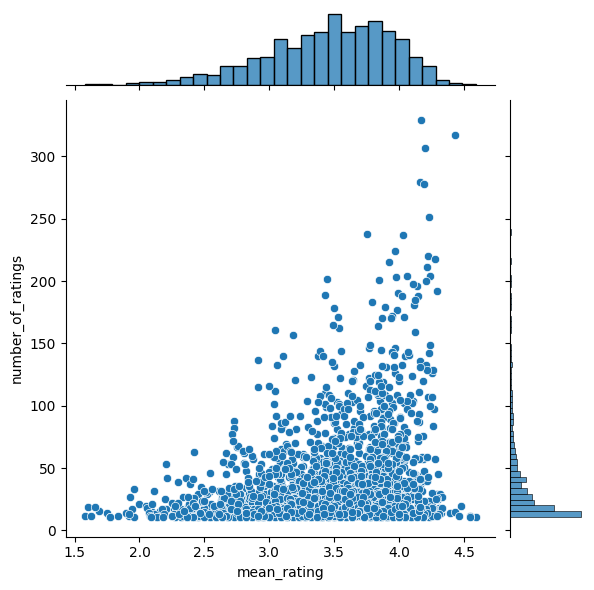

In [183]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT10)

In [184]:
# most movies have less than 100 ratings.

In [185]:
# Merge data
ratings_df_GT10 = pd.merge(ratings_df, agg_ratings_GT10[['movieId']], on='movieId', how='inner')
ratings_df_GT10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79636 entries, 0 to 79635
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     79636 non-null  int64  
 1   movieId    79636 non-null  int64  
 2   rating     79636 non-null  float64
 3   timestamp  79636 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.4 MB


In [186]:
# Number of users
print('The ratings dataset has', ratings_df_GT10['userId'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', ratings_df_GT10['movieId'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', ratings_df_GT10['rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(ratings_df_GT10['rating'].unique()))


The ratings dataset has 610 unique users
The ratings dataset has 2121 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


2.4 tags for the movies

In [187]:
# Aggregate by movie for tags
agg_tags = tags_df.groupby('movieId').agg(number_of_tags = ('tag', 'count')).reset_index()

In [188]:
agg_tags['number_of_tags'].describe()

count    1572.000000
mean        2.342875
std         5.562342
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       181.000000
Name: number_of_tags, dtype: float64

<Axes: >

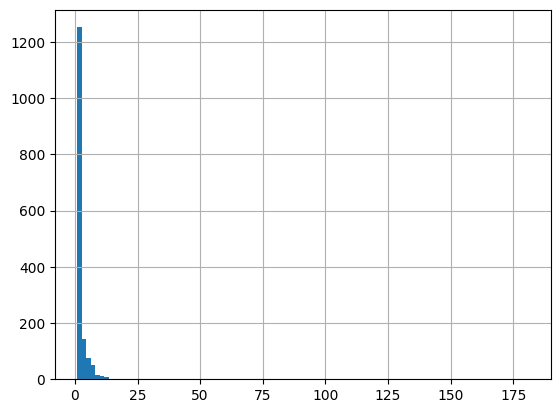

In [189]:
agg_tags['number_of_tags'].hist(bins=100)

In [190]:
# 65% of movies have only 1 tag
sum(agg_tags['number_of_tags'] > 1) / len(agg_tags)

0.3549618320610687

In [191]:
tags_df_agg = tags_df.groupby(['userId', 'movieId'])['tag'].count().reset_index()

3, Create User-Movie Matrix


3.1 Merge Usr-Movie interaction tables

In [192]:
# rename(columns={"A": "a", "B": "c"})
tags_df_agg.rename(columns={"tag": "rating"}, inplace=True)


In [193]:
tags_df_agg

,userId,movieId,rating
0,2,60756,3
1,2,89774,3
2,2,106782,3
3,7,48516,1
4,18,431,3
...,...,...,...
1770,606,6107,1
1771,606,7382,1
1772,606,7936,1
1773,610,3265,2


In [194]:
ratings_df_GT10.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,5,1,4.0,847434962
2,7,1,4.5,1106635946
3,15,1,2.5,1510577970
4,17,1,4.5,1305696483


In [195]:
ratings_df_GT10.drop(columns = ["timestamp"], inplace=True)

In [196]:
user_movies_interaction_df = pd.merge(ratings_df_GT10, tags_df_agg,  how='outer', left_on=['userId','movieId'], right_on = ['userId','movieId'])


In [197]:
user_movies_interaction_df.fillna(0, inplace = True)

In [198]:
user_movies_interaction_df["score"] = user_movies_interaction_df["rating_x"] + user_movies_interaction_df["rating_y"]

In [199]:
user_movies_interaction_df.drop(columns=["rating_x","rating_y"], inplace=True)

3.2 user-item matrix

In [200]:
matrix = user_movies_interaction_df.pivot_table(index='userId', columns='movieId', values='score')

In [201]:
matrix.head()

movieId,1,2,3,5,6,7,9,10,11,12,...,177765,179401,179819,180031,180985,183611,184471,187593,187595,193565
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3.3 Data Normalization

give a higher rating than others, we normalize the rating by extracting the average rating of each user.

In [202]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.fillna(0, inplace=True)
matrix_norm.head()

movieId,1,2,3,5,6,7,9,10,11,12,...,177765,179401,179819,180031,180985,183611,184471,187593,187595,193565
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.387560,0.0,-0.38756,0.0,-0.38756,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.363636,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [203]:
matrix_norm.columns

Index([     1,      2,      3,      5,      6,      7,      9,     10,     11,
           12,
       ...
       177765, 179401, 179819, 180031, 180985, 183611, 184471, 187593, 187595,
       193565],
      dtype='int64', name='movieId', length=2793)

4 Collaborative Filtering


In [204]:

class CollaborativeFiltering:
    def __init__(self, dataframe, k = 10):
        self.dataframe = dataframe.copy()
        self.user_similarities = None
        self.k = k

    def fit(self):
        # Calculate cosine similarity between users
        self.user_similarities = cosine_similarity(self.dataframe)
        self.user_similarities = pd.DataFrame(
            self.user_similarities,
            index=self.dataframe.index,
            columns=self.dataframe.index
        )

    def predict(self, user_id):
        # Predict the rating for each item
        if self.user_similarities is None:
            raise ValueError("Fit the model first using the fit() method.")

        # Get similar users
        similar_users = self.user_similarities[user_id].sort_values(ascending=False).index[1: self.k + 1]

        # Get ratings from similar users
        similar_user_ratings = self.dataframe.loc[similar_users]
        # Calculate weighted average rating for unseen items
        weighted_sum = similar_user_ratings.T.dot(self.user_similarities.loc[user_id, similar_users])
        sum_of_weights = self.user_similarities.loc[user_id, similar_users].sum()

        # Recommend unseen items with highest predicted ratings
        predicted_ratings = weighted_sum / (sum_of_weights + 1e-9)
        
        return predicted_ratings
    
    def recommend_items(self, user_id, num_recommendations):
        predicted_ratings = self.predict(user_id)

        recommendations = predicted_ratings.sort_values(ascending=False).index[:num_recommendations]
        
        return recommendations
    
    def batch_predict(self, eval_dataframe):
        # Predict the rating for each item
        if self.user_similarities is None:
            raise ValueError("Fit the model first using the fit() method.")

        _eval_dataframe = eval_dataframe.copy()
        _predictions = pd.DataFrame(index=_eval_dataframe.index, columns=_eval_dataframe.columns)

        for user in _eval_dataframe.index:
            _predictions.loc[user] = self.predict(user)

        return _predictions

    def evaluate(self, eval_dataframe, missing_rating):
        if self.user_similarities is None:
            raise ValueError("Make sure training first.")

        # Flatten actual and predicted ratings for evaluation
        actual_ratings = eval_dataframe.fillna(0).values.flatten()
        
        _predicted_ratings = self.batch_predict(eval_dataframe)
        predicted_ratings = _predicted_ratings.values.flatten()

        # Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
        mse = mean_squared_error(actual_ratings, predicted_ratings)
        rmse = np.sqrt(mse)

        return {'MSE': mse, 'RMSE': rmse}

In [205]:
# Instantiate the CollaborativeFiltering class
collab_filter = CollaborativeFiltering(matrix_norm)

# Fit the model
collab_filter.fit()


In [206]:
collab_filter.predict(2)

movieId
1         0.034797
2         0.000000
3         0.000000
5         0.020954
6         0.000000
            ...   
183611    0.000000
184471    0.000000
187593    0.000000
187595    0.000000
193565    0.000000
Length: 2793, dtype: float64

In [207]:
collab_filter.recommend_items(1, 5)

Index([2858, 2571, 1197, 260, 50], dtype='int64', name='movieId')

5. Model offline evaluation


5.1 Baseline:
    prdice every score as global average

In [208]:
missing_rating = matrix.isnull()

In [209]:
eval_dataframe = matrix_norm.copy()
eval_dataframe = eval_dataframe[~missing_rating]

In [210]:
actual_ratings = eval_dataframe.fillna(0).values.flatten()
global_mean  = eval_dataframe.mean().mean()

In [211]:
dummy_pred = np.full(len(actual_ratings), global_mean)

In [212]:
mean_squared_error(actual_ratings, dummy_pred, squared=False)

0.5762381866931985

5.2 Collbarative evaluation

In [213]:
collab_filter.evaluate(eval_dataframe, missing_rating=missing_rating)

{'MSE': 0.08161203408476514, 'RMSE': 0.2856782002266976}

6. Model recommendation and save


6.1 Model recommendation after filtering watched movies

In [214]:
#user id 1, recommendation 5 movies
number_of_recommendations = 100
user_id = 1


In [215]:
recommend_movies_ids = collab_filter.recommend_items(user_id, number_of_recommendations)

In [216]:
# check if the movied already watched
watched_movies_mask = matrix.loc[user_id].notna()
watched_movies_ids = matrix.loc[user_id].index[watched_movies_mask]

In [217]:
# Find IDs in A that are not in B
ids_in_recommend_not_in_watched = recommend_movies_ids[~recommend_movies_ids.isin(watched_movies_ids)]

In [218]:
recommend_movies_top20_after_filter_watched = ids_in_recommend_not_in_watched

In [219]:
filtered_movies_df = movies_df[movies_df['movieId'].isin(recommend_movies_top20_after_filter_watched)]

In [220]:
recommend_movies_to_user = filtered_movies_df.set_index('movieId').loc[recommend_movies_top20_after_filter_watched]

In [221]:
recommend_movies_to_user

,title,genres
movieId,,
2918,Ferris Bueller's Day Off (1986),Comedy
904,Rear Window (1954),Mystery|Thriller
1193,One Flew Over the Cuckoo's Nest (1975),Drama
1148,Wallace & Gromit: The Wrong Trousers (1993),Animation|Children|Comedy|Crime
1234,"Sting, The (1973)",Comedy|Crime
...,...,...
1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi
1673,Boogie Nights (1997),Drama
1784,As Good as It Gets (1997),Comedy|Drama|Romance


6.2 save the models and related dataframes

In [222]:
# Specify the file path where you want to save the model
model_filename = '../models/cf_model_001.pkl'

In [223]:
import pickle

In [224]:
# Use pickle to save the model to a file
with open(model_filename, 'wb') as model_file:
    pickle.dump(collab_filter, model_file)

In [225]:
# test model can reload

In [226]:
# Use pickle to load the model from the file
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [227]:
# make sure that the saved model behaves as expected by sanity checks
assert (loaded_model.recommend_items(user_id, number_of_recommendations) == collab_filter.recommend_items(user_id, number_of_recommendations)).all()

In [228]:
# save matrix
matrix_filename = '../models/matrix.csv'
matrix.to_csv(matrix_filename) 